### **Content License Agreement**

<font color='red'><b>**WARNING**</b></font> : 본 자료는 삼성청년SW·AI아카데미의 컨텐츠 자산으로, 보안서약서에 의거하여 어떠한 사유로도 임의로 복사, 촬영, 녹음, 복제, 보관, 전송하거나 허가 받지 않은 저장매체를 이용한 보관, 제3자에게 누설, 공개 또는 사용하는 등의 무단 사용 및 불법 배포 시 법적 조치를 받을 수 있습니다.

# **Objectives**

1. 과제 개요
  - 사전 학습된 CNN 모델(ResNet-18)을 활용한 리니어 프로빙 (Linear Probing)
  - 자동 데이터 증강의 적용 (Auto - Augmentation) 및 미세 조정 (Fine-tuning) 을 통한 성능 향상
  - HuggingFace ViT 모델을 통한 최신 트랜스포머 기반 모델 가중치 활용 진행

2. 과제 진행 목적 및 배경
  - 전이 학습(Transfer Learning)의 개념과 확장적 사용법
  - 사전 학습된 모델 가중치의 부분적 활용을 통한 훈련 가속
  - CNN 기반 모델과 Transformer 기반 모델의 차이 및 활용법 비교
  - PyTorch 및 HuggingFace 생태계 간 상호작용 예시

3. 과제 수행으로 얻어갈 수 있는 역량
  - ResNet-18과 같은 CNN 모델 구조 및 전이 학습 주의사항 숙지
  - Linear Probing과 Partial Fine-tuning의 사용성 차이 이해
  - Automatic Data Augmentation 패키지 활용을 통한 효율적인 성능 개선 기법 적용 능력
  - HuggingFace 모델 로딩 및 Inference Pipeline 활용법 실습

4. 과제 핵심 내용
  - 사전 학습된 ResNet-18 모델의 마지막 레이어만 학습 (Linear Probing)
  - 전체 모델을 대상으로 Fine-tuning 수행 (with Augmentation & Scheduler)
  - HuggingFace의 Vision Transformer(ViT) 모델로 CIFAR-10 이미지 추론
  - 학습 결과의 정확도 비교 및 전이 학습의 효과 체험


# **Prerequisites**
```
(예시)
transformers >= 4.2.1
pytorch >= 1.7.1
pandas == 1.5.3
numpy >= 1.19.2
```


# 과제 01 : 목표 데이터셋에 기존 학습된 모델 적응시키기

**학습 목표**

실습 시간에 배운 전이 학습(Transfer Learning) 기법을 활용하여, 컴퓨터 비전 모델을 목표 데이터셋에 맞게 변형·학습·평가하는 방법을 익힌다.

**학습 개념**
- 부분적 가중치 동결을 활용한 목표 데이터셋에 맞춘 모델 변형의 이해

- 다양한 학습률 스케줄러(Learning Rate Scheduler) 적용 사례 학습

- 최적화 알고리즘(Optimizer) 변경을 통한 학습 성능 개선 방법 습득

**실습 요약**

사전 학습된 모델의 Linear Classifier 및 원하는 Layer를 목표 데이터셋에 맞게 변경하여 훈련한다.

기본 StepLR 이외의 두 가지 Learning Rate Scheduler를 적용해 성능을 비교한다.

학습 과정에서 Optimizer를 변경하며, 목표 일반화 성능 달성 여부를 검증한다.


재현성을 위한 시드 고정부터 진행합니다.

In [1]:
# 시드 설정
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import copy
import matplotlib.pyplot as plt
import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 중인 장치:", device)

사용 중인 장치: cuda


실습과 동일하게, 데이터를 준비합니다.
저희가 사용할 ResNet18은 큰 클래스 갯수와 이미지 사이즈를 가지고 있는 ImageNet에 사전학습이 진행된 모델입니다. 다종다양한 그림에 학습된 모델에 전이학습을 적용하기 위해, 꽃에 집중된 데이터셋인 Flowers102를 사용합니다. torchvision을 이용해 해당 데이터셋을 불러오고, 이전과 동일한 전처리를 적용합니다.

'train','val', 'test' 에 맞는 split을 받아, 3개의 Flowers102 데이터셋 객체를 형성합니다.


In [2]:
# 문제 1. Flowers102 데이터셋 로드
# [TODO] Flowers102 데이터셋을 'train', 'val', 'test' split으로 각각 로드하세요.
# 힌트: datasets.Flowers102의 split 인자에 'train', 'val', 'test'를 각각 전달합니다.
train_dataset_raw = datasets.Flowers102(
    root="./data",
    split="train",
    download=True
)
val_dataset_raw = datasets.Flowers102(
    root="./data",
    split="val",
    download=True
)
test_dataset_raw = datasets.Flowers102(
    root="./data",
    split="test",
    download=True
)


100%|██████████| 345M/345M [00:16<00:00, 20.4MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.93MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 42.6MB/s]


학습 및 평가를 위한 데이터가 준비되었으니, 전처리를 진행합니다. 실습에서 배운 픽셀 평균/분산 계산 법을 활용하여,  Normalization을 위한 파라미터를 계산합니다. 이후 해당 값을 이용해, 전처리를 진행합니다.

# 과제 02. Flowers102 데이터셋 대상 Fine-Tuning
Flowers102는 getitem을 활용할 시 image를 반환합니다.
Flow : 이미지를 numpy로 변형, Tensor로 변형, 평균의 계산, 표준편차의 계산
Hint : a = np.array(a)

In [ ]:

data_tensor = torch.from_numpy(np.array(train_dataset_raw.__getitem__(0)[0]))
# 문제 2. 텐서의 평균과 표준편차 계산
# [TODO] 텐서의 픽셀 값을 0~1 범위로 스케일링한 후, 평균과 표준편차를 계산하세요.
# 힌트: 텐서를 255.0으로 나누고, torch.mean()과 torch.std() 함수를 사용합니다.
#       차원(dim)을 (0, 1, 2)로 설정하여 전체 픽셀에 대해 계산합니다.
mean = torch.mean(data_tensor.float() / 255.0, dim=(0, 1, 2))
# 표준편차 계산 (배치, 높이, 너비 차원에 대해)
std = torch.std(data_tensor.float() / 255.0, dim=(0, 1, 2))
print(f"Mean: {mean:.4f}, Std: {std:.4f}")


Mean: 0.4690, Std: 0.2587


In [ ]:
# 문제 3. 데이터 전처리
# [TODO] 위에서 구한 파라미터를 활용하여, 전처리를 진행합니다.
# 데이터 변환기 정의
# 학습 데이터: 224로 리사이즈 후 텐서화 및 정규화


# 이전 파이썬 실습에서 배운, class 형식으로 transform을 위한 클래스를 만듭시다.
# 호출되었을 시, 들어온 입력을 numpy array로 변환하는 변환입니다.
# 예상 필요 코드 라인 수 : 3

class ToNumpy:
    # BEGIN
    def __call__(self, img):
        return np.array(img)
    # END

#위에서 만든 새 변환과 함께, Transform을 구성합니다.
#Hint : ToNumpy는 ToTensor 이전에 호출합니다.

train_transform = transforms.Compose([
    transforms.Resize([224,224]),  # ResNet18 입력 크기인 224x224로 크기 변경
    ToNumpy(),
    transforms.ToTensor(),   # PyTorch 텐서로 변환
    transforms.Normalize(mean,std)
])

# 테스트 데이터: 리사이즈 후 텐서화 및 정규화 (학습과 동일하게)
test_transform = transforms.Compose([
    transforms.Resize([224,224]),
    ToNumpy(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 문제 4. 데이터셋 객체 생성
# [TODO] 위에서 정의한 transform을 적용하여 데이터셋 객체를 다시 생성하세요.
# 힌트: datasets.Flowers102의 transform 인자에 위에서 만든 변환기를 전달합니다.
train_dataset = datasets.Flowers102(
    root="./data",
    split="train",
    transform=train_transform,
    download=True
)
val_dataset = datasets.Flowers102(
    root="./data",
    split="val",
    transform=test_transform,
    download=True
)
test_dataset = datasets.Flowers102(
    root="./data",
    split="test",
    transform=test_transform,
    download=True
)
# DataLoader를 통해 배치 구성
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print("훈련 배치 개수:", len(trainloader), "테스트 배치 개수:", len(testloader))

훈련 배치 개수: 16 테스트 배치 개수: 97


In [ ]:
# Assertion 01.

# 세 데이터셋 객체가 서로 다른지 확인
assert train_dataset != val_dataset
assert train_dataset != test_dataset
assert val_dataset != test_dataset

print("세 데이터셋 객체가 서로 다릅니다.")

# 각 데이터셋의 split 확인
print(f"train_dataset split: {train_dataset._split}")
print(f"val_dataset split: {val_dataset._split}")
print(f"test_dataset split: {test_dataset._split}")

# 각 데이터셋의 split이 예상하는 값과 일치하는지 확인
assert train_dataset._split == 'train'
assert val_dataset._split == 'val'
assert test_dataset._split == 'test'

print("각 데이터셋의 split이 예상하는 값과 일치합니다.")

세 데이터셋 객체가 서로 다릅니다.
train_dataset split: train
val_dataset split: val
test_dataset split: test
각 데이터셋의 split이 예상하는 값과 일치합니다.


실습과 동일한 과정으로 모델을 수정하겠습니다.

In [ ]:
# 사전 학습된 ResNet-18 모델 불러오기 (ImageNet 가중치 사용)
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
# 모델 내부 모듈들의 이름 확인
for n in model.named_modules():
  print(n)

# 문제 5. 모델 수정
# [TODO] 모델의 최종 출력 레이어(fc)를 Flowers102의 클래스 수(102)에 맞게 교체하세요.
# 힌트: model.fc.in_features를 사용하여 입력 피쳐 수를 가져오고, nn.Linear로 새로운 레이어를 만듭니다.
N = 102
model.fc = nn.Linear(model.fc.in_features, N)


# 문제 6. 모델 파라미터 동결
# [TODO] `fc` 레이어와 `layer4`를 제외한 모든 파라미터를 동결시키세요.
# 힌트: model.named_parameters()로 루프를 돌며, 파라미터 이름(name)에 'fc' 또는 'layer4'가 포함되지 않으면
#       param.requires_grad를 False로 설정합니다.
for name, param in model.named_parameters():
    if "fc" not in name:  # fc 층이 아닌 경우
        param.requires_grad = False
    if "layer4" in name:
        param.requires_grad = True


model_before_train_dict = copy.deepcopy(model.state_dict())
# 장치를 GPU로 이동
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


('', ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [ ]:
# Assertion 2. 모델의 Gradient는 알맞게 기록되었는가?
for n, p in model.named_parameters():
    if "fc" in n:
        assert p.requires_grad == True
    elif "layer4" in n:
        assert p.requires_grad == True
    else:
        assert p.requires_grad == False

print("모델의 Gradient가 알맞게 Freeze 되었습니다.")


모델의 Gradient가 알맞게 Freeze 되었습니다.


앞선 실습과 다르게,  이번에 진행하는 것은 Linear Layer만 최적화하지 않습니다. 최종 linear layer 이외 마지막 4번째 Block 또한 학습시켜, 조금 더 목표하는 데이터셋에 맞도록 변화시키며, 동시에 원본의 지식을 얼마나 잃는가 확인합니다.

#### 모델 학습을 위해 손실함수, 옵티마이저, 학습률, 에포크 수 등을 설정합니다.
1. 손실 함수 (criterion) 로는 다중 클래스 분류를 위한 크로스 엔트로피 오차(nn.CrossEntropyLoss)를 사용합니다.
2. 옵티마이저 (optimizer) 로는 분류층 파라미터만 업데이트하도록 SGD(Stochastic Gradient Descent)를 사용합니다.
3. 학습률(lr)은 예시로 0.01로 설정합니다.
4. 에포크 수 (epochs) 는 5로 설정합니다.

In [ ]:
from tqdm import tqdm
# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의, 학습률은 0.001 으로 설정

# 문제 7. Optimizer와 Scheduler 정의
# [TODO] Optimizer와 Scheduler를 정의하세요.
# 힌트 1 (Optimizer): optim.SGD를 사용하고, 학습률(lr)=0.001, momentum=0.9로 설정합니다.
# 힌트 2 (Scheduler): optim.lr_scheduler.StepLR을 사용하고, step_size=5, gamma=0.1로 설정합니다.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 에포크 수 설정
num_epochs = 10
naive_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()  # 학습 모드
    running_loss = 0.0
    # 문제 8. 학습 루프
    # [TODO] 학습 루프의 핵심 로직을 완성하세요.
    for inputs, labels in tqdm(trainloader,leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        # 1. 그래디언트 초기화
        optimizer.zero_grad()           # 이전 미니배치의 그래디언트 초기화
        # 2. 모델 순전파
        outputs = model(inputs)         # 모델 순전파
        # 3. 손실 계산
        loss = criterion(outputs, labels)
        # 4. 역전파
        loss.backward()                 # 역전파
        # 5. 가중치 업데이트
        optimizer.step()                # 가중치 업데이트
        # 6. 손실 기록
        running_loss += loss.item()     # 손실 기록
    avg_loss = running_loss / len(trainloader)
    naive_losses.append(avg_loss)
    scheduler.step()
    print(f"[Epoch {epoch+1}/{num_epochs}] 평균 훈련 손실: {avg_loss:.4f}")




 10%|█         | 1/10 [00:08<01:16,  8.45s/it]

[Epoch 1/10] 평균 훈련 손실: 4.7700



 20%|██        | 2/10 [00:14<00:58,  7.32s/it]

[Epoch 2/10] 평균 훈련 손실: 4.4503



 30%|███       | 3/10 [00:22<00:50,  7.21s/it]

[Epoch 3/10] 평균 훈련 손실: 4.1181



 40%|████      | 4/10 [00:28<00:41,  6.94s/it]

[Epoch 4/10] 평균 훈련 손실: 3.7827



 50%|█████     | 5/10 [00:35<00:35,  7.04s/it]

[Epoch 5/10] 평균 훈련 손실: 3.4703



 60%|██████    | 6/10 [00:42<00:28,  7.04s/it]

[Epoch 6/10] 평균 훈련 손실: 3.2607



 70%|███████   | 7/10 [00:49<00:20,  6.92s/it]

[Epoch 7/10] 평균 훈련 손실: 3.2255



 80%|████████  | 8/10 [01:00<00:16,  8.33s/it]

[Epoch 8/10] 평균 훈련 손실: 3.2039



 90%|█████████ | 9/10 [01:10<00:08,  8.84s/it]

[Epoch 9/10] 평균 훈련 손실: 3.1713



100%|██████████| 10/10 [01:17<00:00,  7.73s/it]

[Epoch 10/10] 평균 훈련 손실: 3.1404


In [ ]:
model.eval()  # 평가 모드로 설정 (드롭아웃/배치정규화 비활성화 등)
correct = 0
total = 0
with torch.no_grad():  # 평가 시에는 no_grad()로 메모리 절약
    for inputs, labels in tqdm(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # 가장 높은 값의 인덱스를 예측으로 간주
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"테스트 데이터 정확도: {accuracy:.2f}%")


100%|██████████| 97/97 [00:40<00:00,  2.40it/s]

테스트 데이터 정확도: 40.10%


실습에선 Augmentation을 이용한 성능 향상을 배워보았습니다. 과제에서는, 추가적인 LR Scheduler와 Optimizer를 사용해보고, 차이점을 확인합니다.

In [ ]:
# 모델의 상태를 학습 전으로 되돌립니다.
model.load_state_dict(model_before_train_dict)

<All keys matched successfully>

실습과 이전 코드에서 사용하던 Optimizer는 Momentum 옵티마이저로, 쉽게 정리하여 이전 진행방향으로의 이동에 대한 성분을 이번 진행방향에 조금 더 반영해 진행하던 방향으로 조금 더 빠르게 진행하도록 작업한 옵티마이저였습니다. 이번에는 가벼운 딥러닝 태스크에서 통상적으로 사용되고, Local Minima의 탈출에 용이한 것으로 유명한 Adam Optimizer를 사용해 보겠습니다.

**Adam Optimizer 수식 및 설명**

Adam(Adaptive Moment Estimation)은 확률적 경사하강법(SGD)의 변형으로, 1차 모멘트(평균)와 2차 모멘트(분산 추정치)를 모두 활용하여 학습률을 적응적으로 조정하는 최적화 알고리즘입니다.

초기화:  
m₀ = 0,  v₀ = 0,  t = 0

하이퍼파라미터:  
α (학습률), β₁ (1차 모멘트 감쇠율), β₂ (2차 모멘트 감쇠율), ε (수치 안정성)

1. **시점 업데이트**  
t ← t + 1

2. **1차 모멘트 추정**  
mₜ = β₁·mₜ₋₁ + (1 − β₁)·gₜ

3. **2차 모멘트 추정**  
vₜ = β₂·vₜ₋₁ + (1 − β₂)·gₜ²

4. **편향 보정**  
m̂ₜ = mₜ / (1 − β₁ᵗ)  
v̂ₜ = vₜ / (1 − β₂ᵗ)

5. **파라미터 업데이트**  
θₜ = θₜ₋₁ − α · m̂ₜ / (√v̂ₜ + ε)

---

여기서,  
- gₜ은 시점 t에서의 기울기입니다.  
- mₜ은 기울기의 지수이동평균(1차 모멘트)입니다.  
- vₜ은 기울기 제곱의 지수이동평균(2차 모멘트)입니다.  
- m̂ₜ, v̂ₜ은 초기 편향을 보정한 모멘트 추정치입니다.  
- β₁, β₂는 각각 1차, 2차 모멘트의 감쇠율이며, 일반적으로 β₁ = 0.9, β₂ = 0.999입니다.  
- ε은 0으로 나누는 것을 방지하는 작은 상수이며, 예를 들어 10⁻⁸을 사용합니다.  


#### **간단히 요약하여, 최근 기울기의 평균이 되는 방향(1차 모멘트)으로 최근 기울기들의 분산값이 반영된 속도로 움직이는 알고리즘입니다.**

더 쉽게 말해, 평균적인 가던 방향으로 최근 기울기가 크게 변했다면 안정성을 위해 느리게, 그렇지 않다면 속도를 유지하는 알고리즘입니다.


**Learning Rate Scheduler**

`ReduceLROnPlateau`는 모델의 성능 지표(예: 검증 손실, 검증 정확도)가 일정 기간 동안 향상되지 않을 경우 학습률을 자동으로 감소시키는 스케줄러입니다. 주로 학습이 정체 상태(plateau)에 도달했을 때, 더 세밀한 학습을 유도하기 위해 사용됩니다.

---

**작동 방식**  
1. 사용자가 지정한 모니터 지표를 추적합니다.  
2. 해당 지표가 `patience`로 지정된 기간 동안 개선되지 않으면 학습률을 줄입니다.  
3. 학습률 감소 비율은 `factor`로 지정하며,  
   새 학습률 = 기존 학습률 × factor 로 계산됩니다.  
4. 최소 학습률(`min_lr`) 이하로는 감소하지 않습니다.

---

**주요 파라미터**
- **monitor** : 추적할 성능 지표 (예: "val_loss")  
- **factor** : 학습률 감소 비율 (예: 0.1 → 10%로 줄임)  
- **patience** : 성능 향상이 없더라도 기다릴 epoch 수  
- **mode** : 'min' 또는 'max' (감소 방향에 따라 선택)  
- **min_lr** : 학습률의 하한선  

---

**예시**  
- monitor = "val_loss", mode = "min"  
- factor = 0.1, patience = 2
- 검증 손실이 2 epoch 동안 감소하지 않으면 학습률을 10%로 줄입니다.

**아래 코드에서 Adam은 $\beta_1 = 0.9, \beta_2 = 0.99, \epsilon=10^{-8}$을 사용합니다**

In [ ]:
# 문제 9. Optimizer와 Scheduler를 새로 정의
# [TODO] Optimizer와 Scheduler를 새로 정의하세요.
# 힌트 1 (Optimizer): optim.Adam을 사용하고, 학습률(lr)=0.001로 설정합니다.
# 힌트 2 (Scheduler): optim.lr_scheduler.ReduceLROnPlateau를 사용하고, mode='min', factor=0.1, patience=2로 설정합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',       # val_loss가 감소해야 개선으로 판단
    factor=0.1,       # 학습률을 10%로 감소
    patience=2,       # 3 epoch 동안 개선 없으면 감소
    min_lr=1e-6       # 최소 학습률
)
#END


Validation Loss를 기준으로 작동하는 알고리즘인 만큼, 위에서 생성해둔 Val_dataset을 사용해 Val loss에 따라 스케쥴러를 작동합니다. 스케쥴러의 Patience는 호출되는 때 카운트가 올라가므로, 적합한 지점에서 호출하며, 이 때 평균 Val_loss를 전달해줍니다.

In [ ]:
# 에포크 수 설정
num_epochs = 10
new_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()  # 학습 모드
    running_loss = 0.0
    # 문제 10. 학습 루프
    # [TODO] 학습 루프의 핵심 로직을 완성하세요.

    for inputs, labels in tqdm(trainloader,leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # 문제 11. 검증 루프
    # [TODO] 검증(Validation) 루프를 작성하여 평균 검증 손실(avg_val_loss)을 계산하세요.
    # 힌트: torch.no_grad() 블록 안에서 model.eval() 모드로 val_loader를 반복합니다.
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        avg_val_loss = val_loss / len(valloader)
        scheduler.step(avg_val_loss)


    # END
    avg_loss = running_loss / len(trainloader)
    new_losses.append(avg_loss)
    print(f"[Epoch {epoch+1}/{num_epochs}] 평균 훈련 손실: {avg_loss:.4f}")


 10%|█         | 1/10 [00:13<02:00, 13.41s/it]

[Epoch 1/10] 평균 훈련 손실: 3.1275



 20%|██        | 2/10 [00:26<01:46, 13.29s/it]

[Epoch 2/10] 평균 훈련 손실: 0.5875



 30%|███       | 3/10 [00:39<01:33, 13.33s/it]

[Epoch 3/10] 평균 훈련 손실: 0.0818



 40%|████      | 4/10 [00:53<01:19, 13.32s/it]

[Epoch 4/10] 평균 훈련 손실: 0.0206



 50%|█████     | 5/10 [01:06<01:06, 13.29s/it]

[Epoch 5/10] 평균 훈련 손실: 0.0101



 60%|██████    | 6/10 [01:19<00:53, 13.26s/it]

[Epoch 6/10] 평균 훈련 손실: 0.0061



 70%|███████   | 7/10 [01:33<00:39, 13.32s/it]

[Epoch 7/10] 평균 훈련 손실: 0.0046



 80%|████████  | 8/10 [01:47<00:26, 13.48s/it]

[Epoch 8/10] 평균 훈련 손실: 0.0040



 90%|█████████ | 9/10 [02:00<00:13, 13.39s/it]

[Epoch 9/10] 평균 훈련 손실: 0.0033



100%|██████████| 10/10 [02:13<00:00, 13.38s/it]

[Epoch 10/10] 평균 훈련 손실: 0.0029


학습이 완료되었다면, 다시 Test 성능을 측정합니다.

In [ ]:
model.eval()  # 평가 모드로 설정 (드롭아웃/배치정규화 비활성화 등)
correct = 0
total = 0
with torch.no_grad():  # 평가 시에는 no_grad()로 메모리 절약
    for inputs, labels in tqdm(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # 가장 높은 값의 인덱스를 예측으로 간주
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Optimizer, Scheduler 변경 후 테스트 데이터 정확도: {accuracy:.2f}%")

100%|██████████| 97/97 [00:54<00:00,  1.78it/s]

Optimizer, Scheduler 변경 후 테스트 데이터 정확도: 87.84%


### **간단한 시각화 진행**

Training 과정의 수렴 속도를 간단한 시각화로 확인해봅니다.

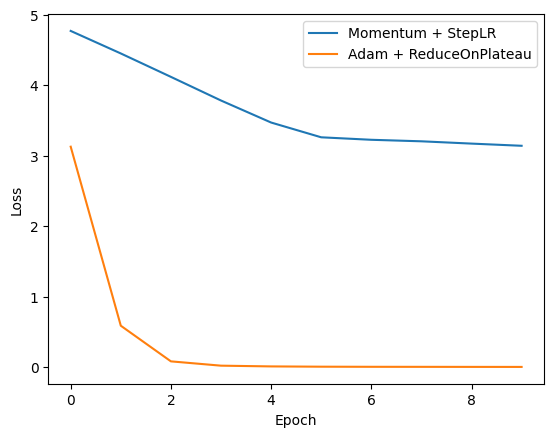

In [ ]:
import matplotlib.pyplot as plt


# plot naive loss vs new optim/scheduler
# naive_losses vs new_losses

plt.figure()
plt.plot(naive_losses, label='Momentum + StepLR')
plt.plot(new_losses, label='Adam + ReduceOnPlateau')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


실습에서 진행한 Augmentation 뿐 아닌, 상황에 적합한 LR Scheduler와 Optimizer의 선택 또한 중요하다는 점을 확인해보았습니다.

일반적으로 수 Epoch 후에 0에 가까워지는 Loss는, 학습 여부를 떠나 모델의 수학적 최적화 (Optimization) 진행 자체가 잘 되고 있음을 나타냅니다.

# 과제 03. HuggingFace Transformers를 활용한 ViT(Vision Transformer) 추론

Huggingface는 트랜스포머 계열 모델들의 간편한 사용과 공유를 위해 사용되던 패키지로, 현재는 많은 AI 태스크의 간편한 진행을 위해 범용적으로 사용됩니다.

그러나, Huggingface의 모델 또한 기본적으로는 PyTorch 모델인 바, 실습에서 진행했던 ViT 태스크를 PyTorch와 조금 더 깊게 섞어 진행해봅시다. 이전 실습에서 사용한 CIFAR10에 학습된 ViT를 그대로 다시 사용합니다.

해당 과제에서, 여러번 반복하여 만들고 있는 Training Loop를 Huggingface model를 기준으로 다시 작성하게 됩니다.

In [ ]:
from datasets import load_dataset
from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name = "nateraw/vit-base-patch16-224-cifar10"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
vit_model = ViTForImageClassification.from_pretrained(model_name)
vit_model.to(device)  # 모델을 GPU로 이동
# CIFAR-10 데이터셋 불러오기 (시간상의 이유로 test 셋)
dataset = load_dataset('cifar10', split='test')


print(dataset)  # 데이터셋 정보 출력

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/918 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


1. 새 Classifier를 정의합시다.
2. 해당 Classifier도 GPU로 옮깁니다.
3. 해당 Classifier를 원본 모델의 Classifier 대신 대체합니다.
4. 위에서 진행한 것과 동일하게, classifier를 제외한 모든 레이어의 Gradient 저장을 멈춥니다.

In [ ]:
# 문제 12. 새 분류기 정의 및 교체
# [TODO] 새 분류기(classifier)를 정의하고, ViT 모델의 분류기를 교체하세요.
# 힌트: nn.Linear(768, 10)으로 새로운 분류기를 정의, GPU로 이동 후 vit_model.classifier에 할당합니다.
new_classifier = nn.Linear(768, 10).to(device)  # 새로운 분류기를 GPU로 이동
vit_model.classifier = new_classifier


# 문제 13. ViT 모델의 레이어 동결
# [TODO] ViT 모델의 분류기(classifier)를 제외한 모든 레이어의 가중치를 동결시키세요.
# 힌트: vit_model.named_parameters() 루프를 돌며, 파라미터 이름에 'classifier'가 없으면 requires_grad를 False로 설정합니다.
for name, param in vit_model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False


## 이번 과제에서, Training loop를 Huggingface에 맞춘다고 하였으나, 사실 작성 자체는 동일합니다. 결과적으로는 동일한 모델이기 때문입니다.

지금까지 배운 모든 작업은, 기본적으로 허깅페이스 모델 및 파이프 내부 모델에 전부 적용 가능합니다.




---



In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
trainset = datasets.CIFAR10(root="./data", train=True, download=True, transform=None)
valset   = datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
batch_size = 64

# collate_fn: 배치의 PIL 이미지를 리스트로 받고 레이블은 텐서로 반환
# collate_fn은 DataLoader가 여러 개의 샘플을 하나의 배치(batch)로 묶을 때, 그 묶는 방식을 직접 정의하는 함수
def collate_fn(batch):
    imgs = [item[0] for item in batch]   # PIL.Image 리스트로 묶기
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long) # 라벨(label)은 텐서(torch.tensor)로 묶기
    return imgs, labels

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
valloader   = DataLoader(valset,   batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)


100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


정상적인 훈련 루프를 다시 짜봅시다. 이전과 동일하게 작성하되, 이미지의 전처리 모델 또한 통과시킬 필요성이 있다는 지점과, 허깅페이스 모델은 내부에 필요한 Loss를 같이 구현해두기 때문에 아래의 형식으로 호출할 시 output 내부 attribute로 loss가 리턴된다는 점이 다릅니다.

**hint : pixel_values = encoded["pixel_values"].to(device)**
        
**hint2 : outputs = vit_model(pixel_values=pixel_values, labels=labels)**


In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
momentum = 0.9
num_epochs = 1
optimizer = optim.SGD(vit_model.parameters(), lr=lr, momentum=momentum)

best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} Train", leave=False)
    for imgs, labels in pbar:
        # 문제 14. ViT 모델 학습 루프
        # [TODO] ViT 모델 학습 루프의 핵심 로직을 완성하세요.
        # 1. feature_extractor를 사용하여 이미지를 전처리하고, 결과를 텐서로 변환합니다.
        encoded = feature_extractor(images=imgs, return_tensors="pt")
        pixel_values = encoded["pixel_values"].to(device)    # (B, C, H, W)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * pixel_values.size(0)
        preds = outputs.logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        avg_loss = running_loss / total
        acc = 100.0 * correct / total
        pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:.2f}%")

    train_avg_loss = running_loss / total
    train_acc = correct / total
    print(f"[Epoch {epoch+1}/{num_epochs}] 평균 훈련 손실: {train_avg_loss:.4f}, Train Acc: {100.*train_acc:.2f}%")


[Epoch 1/1] 평균 훈련 손실: 0.2140, Train Acc: 98.44%


## 실습과 동일한 코드로 평가해봅시다.

In [ ]:
# 데이터셋에서 첫 5개 샘플 추출
sample_images = [dataset[i]['img'] for i in range(5)]
true_labels = [dataset[i]['label'] for i in range(5)]
print("실제 레이블:", true_labels)
# 문제 14. 샘플 이미지 전처리
# [TODO] 추출한 샘플 이미지를 FeatureExtractor로 전처리합니다.
# 힌트: feature_extractor를 사용합니다.
# 미지를 모델에 직접 넣을 수는 없고, 정확한 해상도·정규화·텐서 포맷으로 바꿔줘야 함
inputs = feature_extractor(images=sample_images, return_tensors="pt") # 모델이 이해할 수 있는 입력 형태로 전처리해주는 객체
inputs = {k: v.to(device) for k,v in inputs.items()}  # device로 이동
# 문제 15. ViT 모델 예측
# [TODO] ViT 모델을 사용하여 예측을 수행합니다.
outputs = vit_model(**inputs)
logits = outputs.logits  # 모델 출력 로짓(logits)
predicted_class_idxs = logits.argmax(dim=1).cpu().numpy()
print("모델 예측 클래스 인덱스:", predicted_class_idxs)
predicted_labels = [labels[idx] for idx in predicted_class_idxs]
print("모델 예측 클래스 이름:", predicted_labels)



실제 레이블: [3, 8, 8, 0, 6]
모델 예측 클래스 인덱스: [3 8 8 0 6]
모델 예측 클래스 이름: [tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(7, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0')]


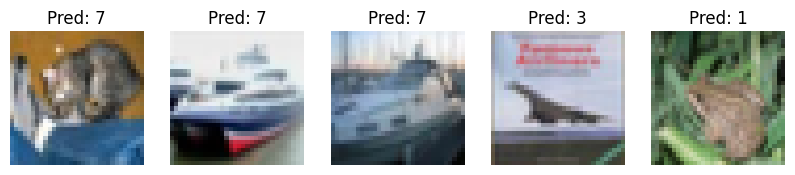

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,2))
for i, img in enumerate(sample_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {predicted_labels[i]}")
    plt.axis('off')
plt.show()

새롭게 초기화한 분류기를 가져왔음에도 불구하고, 짧은 트레이닝으로 성능을 대부분 되찾은 모습을 볼 수 있습니다.
또한 이렇게 만들어낸 모델은, 그대로 다시 pipeline에 주입해 사용할 수 있습니다.

In [ ]:
from transformers import pipeline

clf = pipeline(
    "image-classification",
    model=vit_model,
    feature_extractor=feature_extractor,
    device=0  # GPU 사용 시, CPU면 device=-1
)

preds = clf(sample_images)

# 예측 결과를 더 읽기 쉽게 출력
print("Pipeline 예측 결과:")
for i, pred_list in enumerate(preds):
    print(f"이미지 {i+1}:")
    for pred in pred_list:
        # 'LABEL_X' 문자열에서 레이블 인덱스 추출
        label_index = int(pred['label'].split('_')[1])
        print(f"  - 레이블: {labels[label_index]}, 신뢰도: {pred['score']:.4f}")


Device set to use cuda:0


Pipeline 예측 결과:
이미지 1:
  - 레이블: 7, 신뢰도: 0.9793
  - 레이블: 0, 신뢰도: 0.0029
  - 레이블: 4, 신뢰도: 0.0027
  - 레이블: 3, 신뢰도: 0.0024
  - 레이블: 8, 신뢰도: 0.0024
이미지 2:
  - 레이블: 7, 신뢰도: 0.9781
  - 레이블: 4, 신뢰도: 0.0031
  - 레이블: 3, 신뢰도: 0.0027
  - 레이블: 1, 신뢰도: 0.0025
  - 레이블: 9, 신뢰도: 0.0024
이미지 3:
  - 레이블: 7, 신뢰도: 0.9695
  - 레이블: 4, 신뢰도: 0.0078
  - 레이블: 0, 신뢰도: 0.0037
  - 레이블: 1, 신뢰도: 0.0031
  - 레이블: 0, 신뢰도: 0.0028
이미지 4:
  - 레이블: 3, 신뢰도: 0.9710
  - 레이블: 9, 신뢰도: 0.0065
  - 레이블: 8, 신뢰도: 0.0037
  - 레이블: 1, 신뢰도: 0.0032
  - 레이블: 7, 신뢰도: 0.0031
이미지 5:
  - 레이블: 1, 신뢰도: 0.9760
  - 레이블: 1, 신뢰도: 0.0030
  - 레이블: 8, 신뢰도: 0.0030
  - 레이블: 4, 신뢰도: 0.0028
  - 레이블: 0, 신뢰도: 0.0027


## 마치며

이번 과제에서는, 실습과 유사한 코드를 작성하되 실습에서 지나간 optimizer와 lr scheduler의 성능에 대한 영향에 대해 다루었으며, 특정 전문 데이터셋에 집중해 모델을 재훈련하는 방법을 알아보았습니다. Linear Layer에 국한되지 않고 연산이 이어져 있다면 추가로 부분적인 훈련이 가능함을 알게 되었고, 허깅페이스의 모델들 내부에는 PyTorch 기반의 모델들이 있어 비교적 쉽게 PyTorch 처럼 활용하고 적용할 수 있음을 알게 되었습니다.